# Activation Functions, Gradient Flow and Dead Neurons

This notebook is heavily based on one from Universitaet van Amsterdam's deep learning course written by Phillip Lippe.

You can see his original filled notebook at:
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial3/Activation_Functions.ipynb)

**Pre-trained models:** 
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/tutorial3)
[![GoogleDrive](https://img.shields.io/static/v1.svg?logo=google-drive&logoColor=yellow&label=GDrive&message=Download&color=yellow)](https://drive.google.com/drive/folders/1sFpZUpDJVjiYEvIqISqfkFizfsTnPf4s?usp=sharing)   


You've been introduced to neural networks last week by Jarvist. In this tutorial, we will take a closer look at the response of each neuron, known as the activation function. We'll investigate the effect of several popular fuctions on the optimization properties in neural networks. 

Activation functions are a crucial part of deep learning models as they add the non-linearity to neural networks. Without non-linearity, the number of layers doesn't really matter as the result will always be some linear combination of the input variables that you could have done in a single neuron.

There is a great variety of activation functions in the literature, and some are more beneficial than others.
The goal of this tutorial is to show the importance of choosing a good activation function (and how to do so), and what problems might occur if we don't.

Before we start, we import our standard libraries and set up basic functions:

In [1]:
## Standard libraries
import os
import json
import math
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

We will define a function to set a seed for the randum numbers used in all libraries we might interact with in this tutorial (here numpy and torch). This allows us to make our training reproducible. However, note that in contrast to the CPU, the same seed on different GPU architectures can give different results. All the prebuilt models linked above here have been trained on an NVIDIA GTX1080Ti.

Additionally, the following cell defines two paths: `DATASET_PATH` and `CHECKPOINT_PATH`. The dataset path is the directory where we will download datasets used in the notebooks. It is recommended to store all datasets from PyTorch in one joined directory to prevent duplicate downloads. The checkpoint path is the directory where we will store trained model weights and additional files. The needed files will be automatically downloaded. 

In [2]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial3"

# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cpu


The following cell downloads all pretrained models we will use in this notebook. These are copies from Philip Lippe's course. The files are stored in a separate [repository](https://github.com/pjdunne/saved_models). Please let me (Patrick) know if an error occurs so it can be fixed for all students.

In [3]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/pjdunne/saved_models/main/tutorial3/"
# Files to download
pretrained_files = ["FashionMNIST_elu.config", "FashionMNIST_elu.tar", 
                    "FashionMNIST_leakyrelu.config", "FashionMNIST_leakyrelu.tar",
                    "FashionMNIST_relu.config", "FashionMNIST_relu.tar",
                    "FashionMNIST_sigmoid.config", "FashionMNIST_sigmoid.tar",
                    "FashionMNIST_swish.config", "FashionMNIST_swish.tar",
                    "FashionMNIST_tanh.config", "FashionMNIST_tanh.tar"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## Common activation functions

As a first step, we will implement some common activation functions by ourselves. Of course, most of them can also be found in the `torch.nn` package (see the [documentation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for an overview).
However, we'll write our own functions here for a better understanding and insights.

For an easier time of comparing various activation functions, we start with defining a base class from which all our future modules will inherit:

In [4]:
class ActivationFunction(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

Every activation function will be an `nn.Module` so that we can integrate them nicely in a network. We will use the `config` dictionary to store adjustable parameters for some activation functions.

Next, we implement two of the "oldest" activation functions that are still commonly used for various tasks: sigmoid and tanh. 
Both the sigmoid and tanh activation can be also found as PyTorch functions (`torch.sigmoid`, `torch.tanh`) or as modules (`nn.Sigmoid`, `nn.Tanh`). 
Here, you should implement them by hand:

In [5]:
##############################

class Sigmoid(ActivationFunction):
    
    def forward(self, x):
        y = 1 / (1 + torch.exp(-x))
        return y

##############################   
    
class Tanh(ActivationFunction):
    
    def forward(self, x):
        y = torch.tanh(x)
        return y
    
##############################

Another popular activation function that has allowed the training of deeper networks, is the Rectified Linear Unit (ReLU). 

This function just returns the input for inputs greater than 0, and 0 for input less than or equal to 0.

Despite its simplicity of being a piecewise linear function, ReLU has one major benefit compared to sigmoid and tanh: a strong, stable gradient for a large range of values.
Based on this idea, a lot of variations of ReLU have been proposed, of which we will implement the following three: LeakyReLU, ELU, and Swish. 

LeakyReLU: This replaces the zero returned in the negative part of the input with a smaller slope, with gradient given by 'alpha'. This means the gradient is non-zero so gradients can 'flow' also in this part of the input. We'll see what this means later.

ELU: This is similar to the leaky ReLU but replaces the negative part with an exponential decay.

Swish: This is the most recently proposed of these activation functions, and is actually the result of a large experiment with the purpose of finding the "optimal" activation function. Swish returns the input multiplied by the sigmoid of the input.
Compared to the other activation functions, Swish is both smooth and non-monotonic (i.e. contains a change of sign in the gradient). Swish is designed to solve a problem called 'dead neurons' which happens with a standard ReLU. We'll see what this is later, but it is a particular problem with deep networks.
If interested, a more detailed discussion of the benefits of Swish can be found in [this paper](https://arxiv.org/abs/1710.05941) [1].

Now let's implement the four activation functions below, fill in the blanks yourself:

In [6]:
##############################

class ReLU(ActivationFunction):
    
    def forward(self, x):
        y = torch.where(x>0,x,0)
        return y

##############################

class LeakyReLU(ActivationFunction):
    
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha
        
    def forward(self, x):
        y = torch.where(x>0,x,self.config["alpha"]*x)
        return y

##############################
    
class ELU(ActivationFunction):
    
    def forward(self, x):
        y = torch.where(x>0,x,torch.exp(x)-1)
        return y

##############################
    
class Swish(ActivationFunction):
    
    def forward(self, x):
        y = x * torch.sigmoid(x)
        return y
    
##############################

For later usage, we summarize all our activation functions in a dictionary mapping the name to the class object. In case you implement a new activation function by yourself, add it here to include it in future comparisons as well:

In [7]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish
}

### Visualizing activation functions

To get an idea of what each activation function actually does, we will visualize them in the following. 
Next to the actual activation value, the gradient of the function is an important aspect as it is crucial for optimizing the neural network. 
PyTorch allows us to compute the gradients simply by calling the `backward` function:

In [8]:
def get_grads(act_fn, x):
    """
    Computes the gradients of an activation function at specified positions.
    
    Inputs:
        act_fn - An object of the class "ActivationFunction" with an implemented forward pass.
        x - 1D input tensor. 
    Output:
        A tensor with the same size of x containing the gradients of act_fn at x.
    """
    x = x.clone().requires_grad_() # Mark the input as tensor for which we want to store gradients
    out = act_fn(x)
    out.sum().backward() # Summing results in an equal gradient flow to each element in x
    return x.grad # Accessing the gradients of x by "x.grad"

Now we can visualize all our activation functions including their gradients. We've defined some functions for you to fill in to make nice plots of all of the functions:

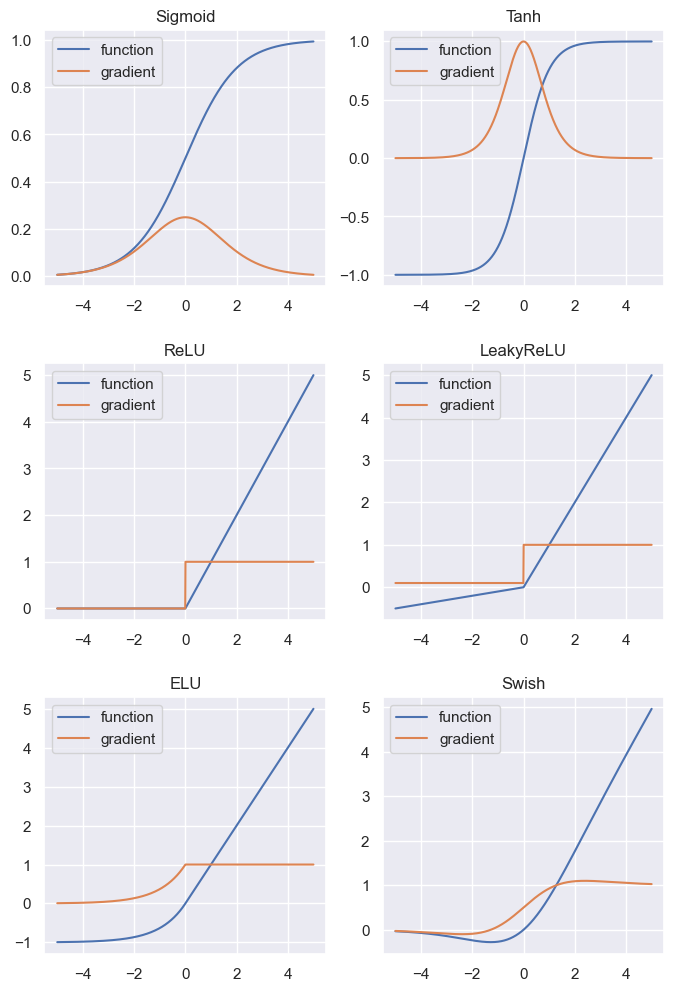

In [9]:
def vis_act_fn(act_fn, ax, x):
    # Run activation function and get gradients
    grad = get_grads(act_fn,x)
    
    # Push x, y and gradients back to cpu for plotting
    y_pred = act_fn(x)
    ax.plot(x, y_pred,label = "function")
    ax.plot(x, grad, label = "gradient")
    ax.legend()
    ax.set_title(act_fn.name)
    
    ## Plotting
    
    return
    
    
# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000) # Range on which we want to visualize the activation functions
## Plotting
rows = math.ceil(len(act_fns)/2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i,2)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

## Analysing the effect of activation functions

After implementing and visualizing the activation functions, we are aiming to gain insights into their effect. 
We do this by using a simple neural network trained on [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) and examine various aspects of the model, including the performance and gradient flow.

### Setup

Firstly, let's set up a neural network. Implement a network to view the images as 1D tensors and push them through a sequence of linear layers and a specified activation function. I've given the function signature below. Feel free to experiment with other network architectures.

In [10]:
class BaseNetwork(nn.Module):
    
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()
        
        # Create the network based on the specified hidden sizes
        layer_sizes = [input_size] + hidden_sizes
        modules = []
        for i in range(len(layer_sizes)-1):
            modules.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            modules.append(act_fn)
        modules.append(nn.Linear(layer_sizes[-1], num_classes))
        self.layers = nn.Sequential(*modules)
        
        # We store all hyperparameters in a dictionary for saving and loading of the model
        self.config = {"act_fn": act_fn.config, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes} 
        
    def forward(self, x):
        x = x.view(x.size(0), -1) # Reshape images to a flat vector
        out = self.layers(x)
        return out    

We also add functions for loading and saving the model. The hyperparameters are stored in a configuration file (simple json file):

In [11]:
def _get_config_file(model_path, model_name):
    # Name of the file for storing hyperparameter details
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    # Name of the file for storing network parameters
    return os.path.join(model_path, model_name + ".tar")

def load_model(model_path, model_name, net=None):
    """
    Loads a saved model from disk.
    
    Inputs:
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
        net - (Optional) If given, the state dict is loaded into this model. Otherwise, a new model is created.
    """
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net
    
def save_model(model, model_path, model_name):
    """
    Given a model, we save the state_dict and hyperparameters.
    
    Inputs:
        model - Network object to save parameters from
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
    """
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

We also set up the dataset we want to train it on, namely [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). FashionMNIST is a more complex version of MNIST and contains black-and-white images of clothes instead of digits. The 10 classes include trousers, coats, shoes, bags and more. To load this dataset, we will make use of yet another PyTorch package, namely `torchvision` ([documentation](https://pytorch.org/docs/stable/torchvision/index.html)). The `torchvision` package consists of popular datasets, model architectures, and common image transformations for computer vision. We will use the package for many of the notebooks in this course to simplify our dataset handling. 

Let's load the dataset below, and visualize a few images to get an impression of the data. FashionMNIST already has the training and test sets separated but we need to split the training and validation sets ourselves.

In [12]:
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Transformations applied on each image => first make them a tensor, then normalize them in the range -1 to 1
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

Let's plot our data:

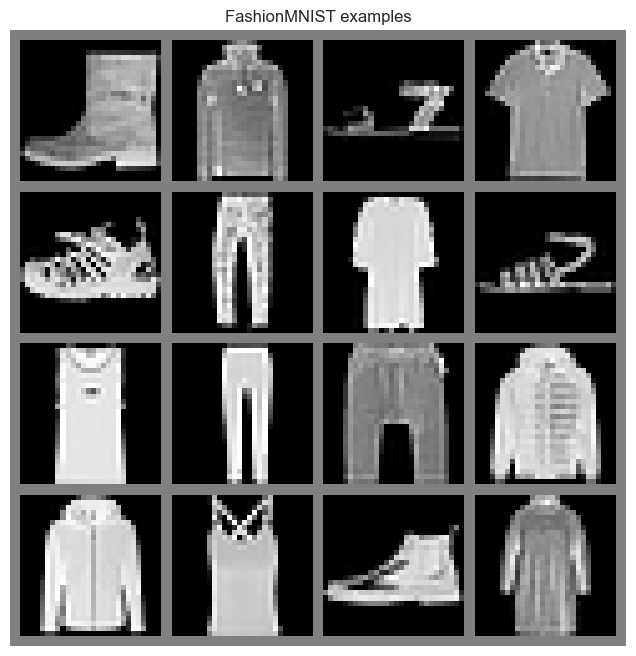

In [13]:
exmp_imgs = [train_set[i][0] for i in range(16)]
# Organize the images into a grid for nicer visualization and plot them
img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

### Gradient flow

Gradient flow describes how activation functions propagate gradients through the network. Imagine we have a very deep neural network with more than 50 layers. The gradients for the input layer, i.e. the very first layer, have passed >50 times the activation function, but we still want them to be of a reasonable size. If the gradient through the activation function is (in expectation) considerably smaller than 1, our gradients will vanish until they reach the input layer. If the gradient through the activation function is larger than 1, the gradients exponentially increase and might explode.

How do you think gradient flow influences choosing a training rate for your network?

To get a feeling of how every activation function influences the gradients, plot a freshly initialized network and measure the gradients for each parameter at the activation function layers of your model (which are these?) for a batch of 256 images:

In [14]:
def visualize_gradients(net, color="C0"):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    
    # Pass one batch through the network, and calculate the gradients for the weights
    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds,labels)
    loss.backward()
    
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name}
    net.zero_grad()
    
    ## Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index%columns]
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
        fig_index += 1
    fig.suptitle(f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}", fontsize=14, y=1.05)
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close() 

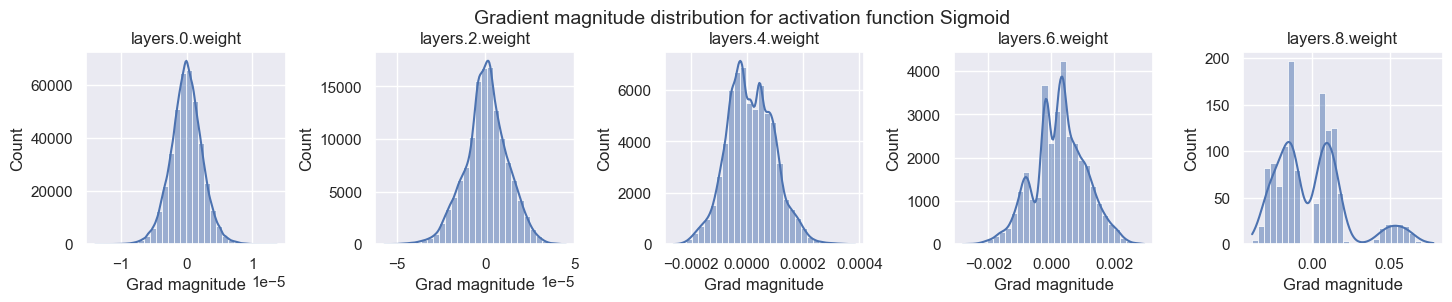

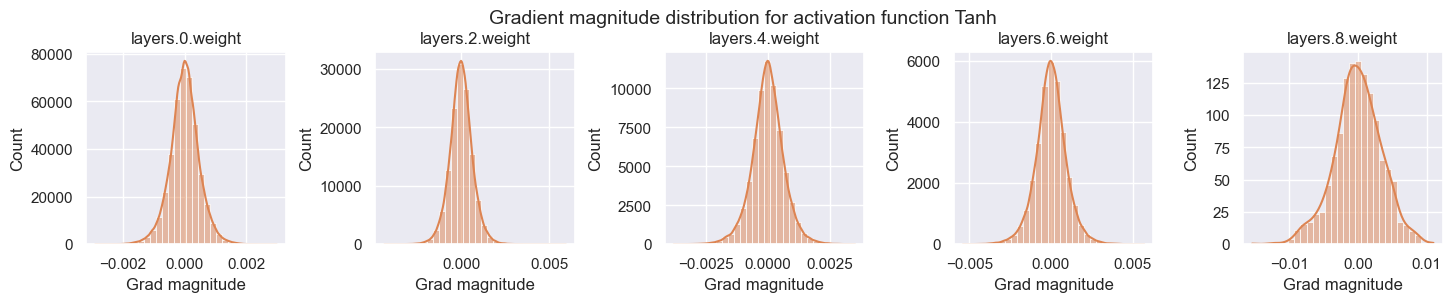

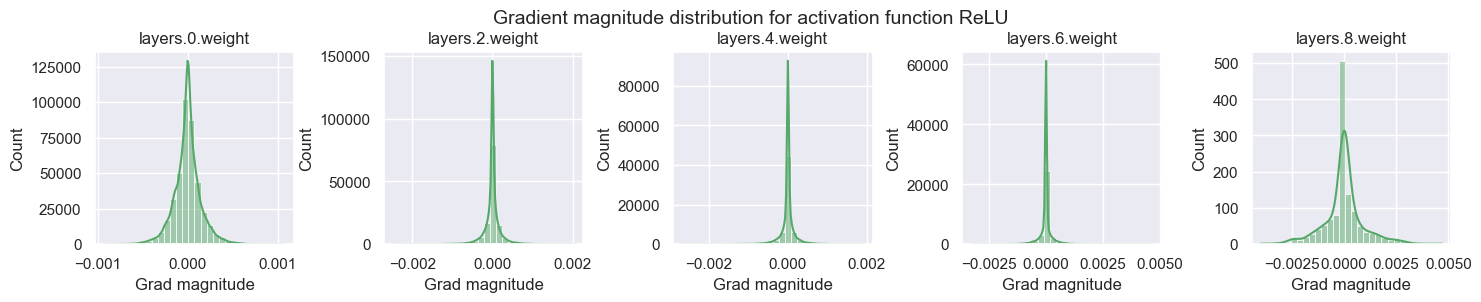

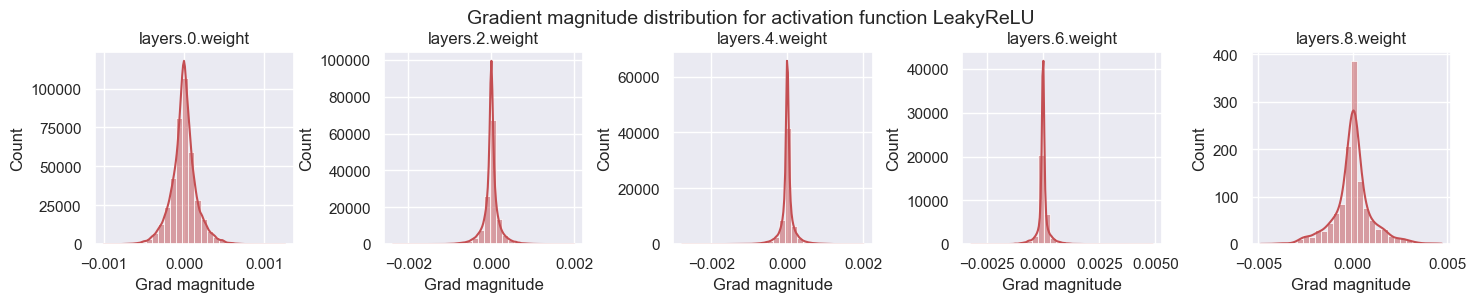

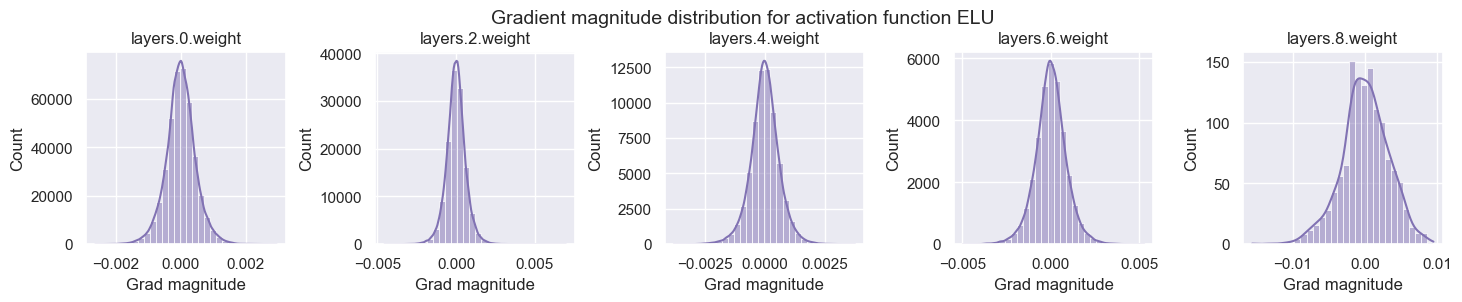

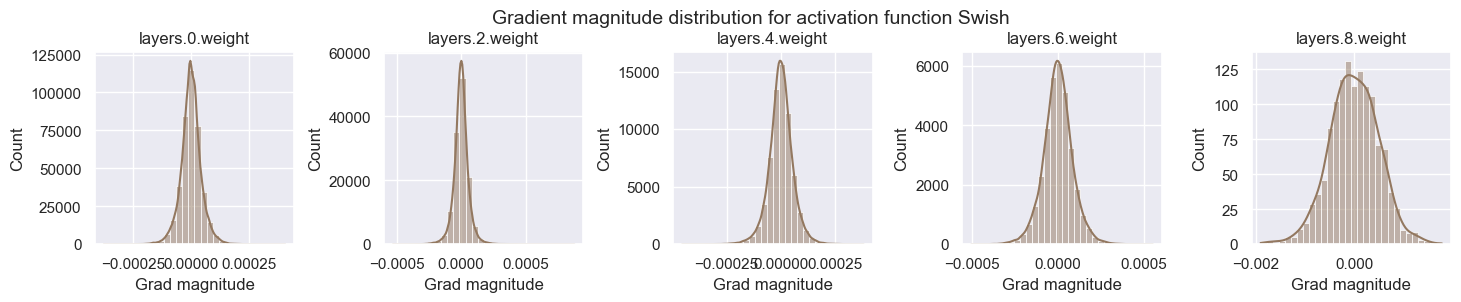

In [15]:
# Seaborn prints warnings if histogram has small values. We can ignore them for now
import warnings
warnings.filterwarnings('ignore')
## Create a plot for every activation function
for i, act_fn_name in enumerate(act_fn_by_name):
    set_seed(42) # Setting the seed ensures that we have the same weight initialization for each activation function
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    visualize_gradients(net_actfn, color=f"C{i}")

The sigmoid activation function shows a clearly undesirable behavior. While the gradients for the output layer are very large with up to 0.1, the input layer has the lowest gradient norm across all activation functions with only 1e-5. This is due to its small maximum gradient of 1/4, and finding a suitable learning rate across all layers is not possible in this setup.
All the other activation functions show to have similar gradient norms across all layers. Interestingly, the ReLU activation has a spike around 0 which is caused by its zero-part on the left, and dead neurons (we will take a closer look at this later on).

Note that additionally to the activation, the initialization of the weight parameters can be crucial. By default, PyTorch uses the [Kaiming](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_) initialization for linear layers optimized for ReLU activations. We could do a whole extra class on initialization, but assume for now that the Kaiming initialization works for all activation functions reasonably well (the Universitet van Amsterdam course has more information on initialisation in lecture 4).

### Training a model

Next, we want to train our model with different activation functions on FashionMNIST and compare the gained performance. All in all, our final goal is to achieve the best possible performance on a dataset of our choice. 
Therefore, you need to write a training loop in the next cell including a validation after every epoch and a final test on the best model:

In [16]:
def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST
    
    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")
            
        # Defining optimizer, loss and data loader
        optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9) # Default parameters, feel free to change
        loss_module = nn.CrossEntropyLoss() 
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0., 0
            for imgs, labels in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device) # To GPU if we have one
                optimizer.zero_grad() # Zero-grad can be placed anywhere before "loss.backward()"
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # Record statistics during training
                true_preds += (preds.argmax(dim=-1) == labels).sum()
                count += labels.shape[0]
            train_acc = true_preds / count

            ##############
            # Validation #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
            elif best_val_epoch <= epoch - patience:
                print(f"Early stopping due to no improvement over the last {patience} epochs")
                break

        # Plot a curve of the validation accuracy
        plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()
    
    load_model(CHECKPOINT_PATH, model_name, net=net)
    test_acc = test_model(net, test_loader)
    print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(50, "=")+"\n")
    return test_acc
    

def test_model(net, data_loader):
    """
    Test a model on a specified dataset.
    
    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc 

We train one model for each activation function.

In [19]:
for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    set_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}", overwrite=False)

Training BaseNetwork with sigmoid activation...
Model file already exists. Skipping training...
============= Test accuracy: 10.00% ==============

Training BaseNetwork with tanh activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.09% ==============

Training BaseNetwork with relu activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.54% ==============

Training BaseNetwork with leakyrelu activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.59% ==============

Training BaseNetwork with elu activation...
Model file already exists. Skipping training...
============= Test accuracy: 87.77% ==============

Training BaseNetwork with swish activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.08% ==============



Which activation functions perform well? Is this what you were expecting from their gradient flow properties?

Not surprisingly, the model using the sigmoid activation function fails and does not improve upon random performance (10 classes => 1/10 for random chance). This is because the gradient of the input layer parameters on the loss function is negligible compared to the other layers.

All the other activation functions gain similar performance.
To have a more accurate conclusion, we would have to train the models for multiple seeds and look at the averages.
However, the "optimal" activation function also depends on many other factors (hidden sizes, number of layers, type of layers, task, dataset, optimizer, learning rate, etc.) so that a thorough grid search would not be useful in our case.
In the literature, activation functions that have shown to work well with deep networks are all types of ReLU functions we experiment with here, with small gains for specific activation functions in specific networks.

### Visualizing the activation distribution

After we have trained the models, we can look at the actual activation values that our found inside the model. For instance, how many neurons are set to zero in ReLU? Where do we find most values in Tanh?
To answer these questions, write a simple function which takes a trained model, applies it to a batch of images, and plots the histogram of the activations inside the network:

In [27]:
def visualize_activations(net, color="C0"):
    activations = {}
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size = 1024)
    imgs, _ = next(iter(small_loader))
    #print(imgs)
    #print(imgs.view(-1))
    with torch.no_grad():
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0),-1)
        for layer_index, layer in enumerate(net.layers[:-1]):
            imgs = layer(imgs)
            activations[layer_index] = imgs.view(-1)
    print(activations)
    ## Plotting
    columns = 4
    rows = math.ceil(len(activations)/columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns*2.7, rows*2.5))
    fig_index = 0
    for key in activations:
        key_ax = ax[fig_index//columns][fig_index%columns]
        sns.histplot(data=activations[key], bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title(f"Layer {key} - {net.layers[key].__class__.__name__}")
        fig_index += 1
    fig.suptitle(f"Activation distribution for activation function {net.config['act_fn']['name']}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close() 
    

{0: tensor([ 0.5844, -0.9736,  0.1316,  ..., -0.0518, -1.0521,  0.2314]), 1: tensor([0.6421, 0.2742, 0.5328,  ..., 0.4870, 0.2588, 0.5576]), 2: tensor([ 0.0307, -0.0557,  0.4061,  ..., -0.0124,  0.1003, -0.0040]), 3: tensor([0.5077, 0.4861, 0.6001,  ..., 0.4969, 0.5251, 0.4990]), 4: tensor([ 0.5994, -0.0719, -0.8251,  ...,  0.1811, -0.0699,  0.1083]), 5: tensor([0.6455, 0.4820, 0.3047,  ..., 0.5451, 0.4825, 0.5271]), 6: tensor([ 0.1278,  0.1638,  0.1573,  ..., -0.0183, -0.2787, -0.1990]), 7: tensor([0.5319, 0.5409, 0.5393,  ..., 0.4954, 0.4308, 0.4504])}


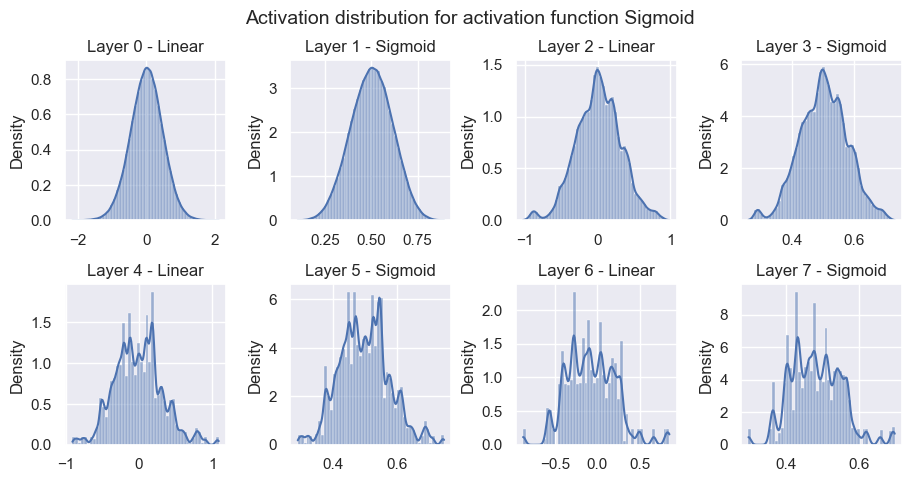

{0: tensor([-0.3286, -0.7060,  0.5550,  ..., -0.1471, -0.3614,  0.3407]), 1: tensor([-0.3173, -0.6082,  0.5043,  ..., -0.1461, -0.3465,  0.3281]), 2: tensor([-0.0933, -0.9495,  1.3919,  ...,  0.4191,  0.1391, -0.3912]), 3: tensor([-0.0930, -0.7395,  0.8836,  ...,  0.3962,  0.1382, -0.3724]), 4: tensor([-1.4759,  1.2759,  0.4149,  ...,  0.3238,  0.3939, -0.0778]), 5: tensor([-0.9007,  0.8554,  0.3926,  ...,  0.3129,  0.3747, -0.0776]), 6: tensor([ 1.0775, -2.4208,  1.4473,  ..., -1.0805, -0.2504, -0.8306]), 7: tensor([ 0.7923, -0.9843,  0.8952,  ..., -0.7934, -0.2453, -0.6808])}


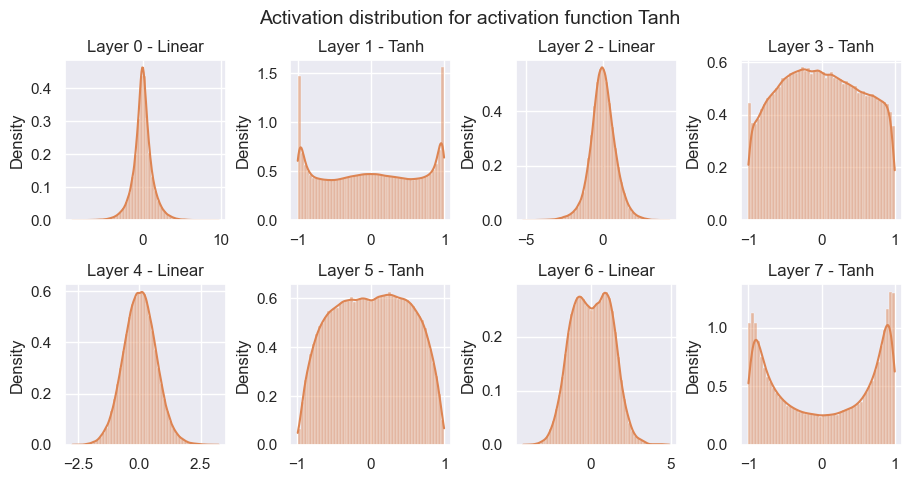

{0: tensor([ 0.3556,  0.1268, -0.3400,  ...,  0.3789, -0.5501,  0.5763]), 1: tensor([0.3556, 0.1268, 0.0000,  ..., 0.3789, 0.0000, 0.5763]), 2: tensor([ 0.4125,  0.7204,  0.8686,  ..., -0.0539,  0.0482,  0.1495]), 3: tensor([0.4125, 0.7204, 0.8686,  ..., 0.0000, 0.0482, 0.1495]), 4: tensor([-0.2181,  1.9086, -0.7914,  ...,  0.5637,  0.7912, -0.0492]), 5: tensor([0.0000, 1.9086, 0.0000,  ..., 0.5637, 0.7912, 0.0000]), 6: tensor([ 2.8848, -1.6297,  2.4815,  ..., -0.2837,  0.6363, -0.1172]), 7: tensor([2.8848, 0.0000, 2.4815,  ..., 0.0000, 0.6363, 0.0000])}


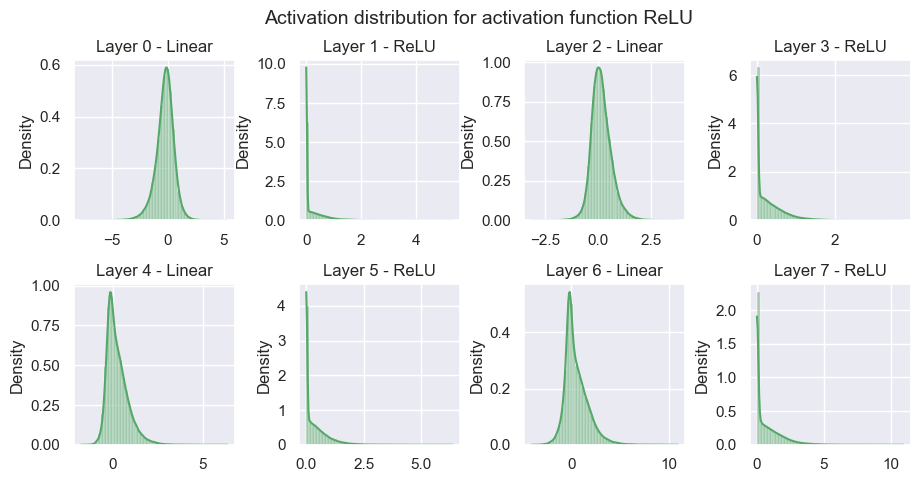

{0: tensor([ 0.2286, -0.2966, -0.7999,  ...,  0.1234, -0.7162,  0.1996]), 1: tensor([ 0.2286, -0.0297, -0.0800,  ...,  0.1234, -0.0716,  0.1996]), 2: tensor([ 0.0366,  0.1487,  0.6361,  ..., -0.2095,  0.0455,  0.2215]), 3: tensor([ 0.0366,  0.1487,  0.6361,  ..., -0.0209,  0.0455,  0.2215]), 4: tensor([-0.2409,  1.9202, -0.7068,  ...,  0.6215,  0.7298, -0.1116]), 5: tensor([-0.0241,  1.9202, -0.0707,  ...,  0.6215,  0.7298, -0.0112]), 6: tensor([ 2.6726, -1.7786,  2.6461,  ..., -0.3668, -0.4643, -0.3917]), 7: tensor([ 2.6726, -0.1779,  2.6461,  ..., -0.0367, -0.0464, -0.0392])}


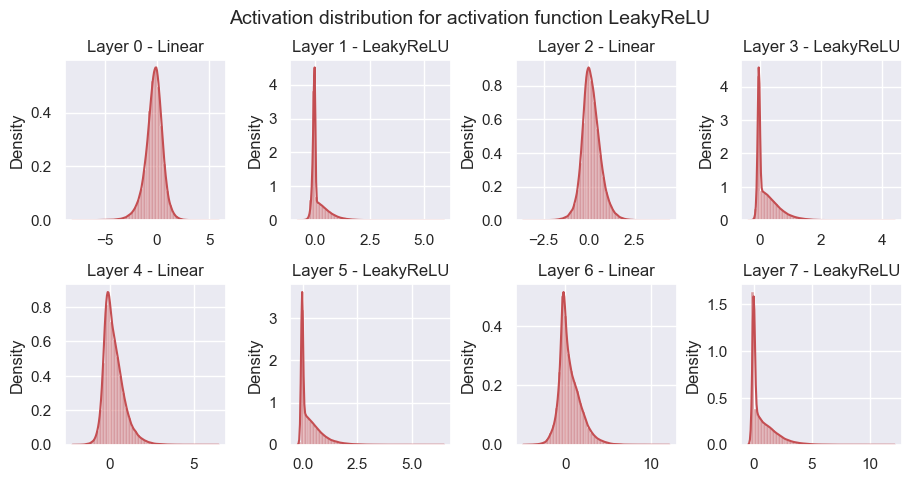

{0: tensor([-0.6256, -0.5510,  0.0268,  ..., -0.3352, -1.3167,  0.0074]), 1: tensor([-0.4651, -0.4236,  0.0268,  ..., -0.2848, -0.7320,  0.0074]), 2: tensor([-0.8015, -1.3591, -0.4967,  ..., -0.5146, -0.3398,  0.1984]), 3: tensor([-0.5513, -0.7431, -0.3915,  ..., -0.4023, -0.2881,  0.1984]), 4: tensor([-2.3955,  0.9806, -0.1409,  ...,  0.2085,  0.1236, -0.2800]), 5: tensor([-0.9089,  0.9806, -0.1314,  ...,  0.2085,  0.1236, -0.2442]), 6: tensor([ 0.4318, -2.8535, -1.0018,  ..., -1.3996, -0.9853, -0.4415]), 7: tensor([ 0.4318, -0.9424, -0.6328,  ..., -0.7533, -0.6267, -0.3570])}


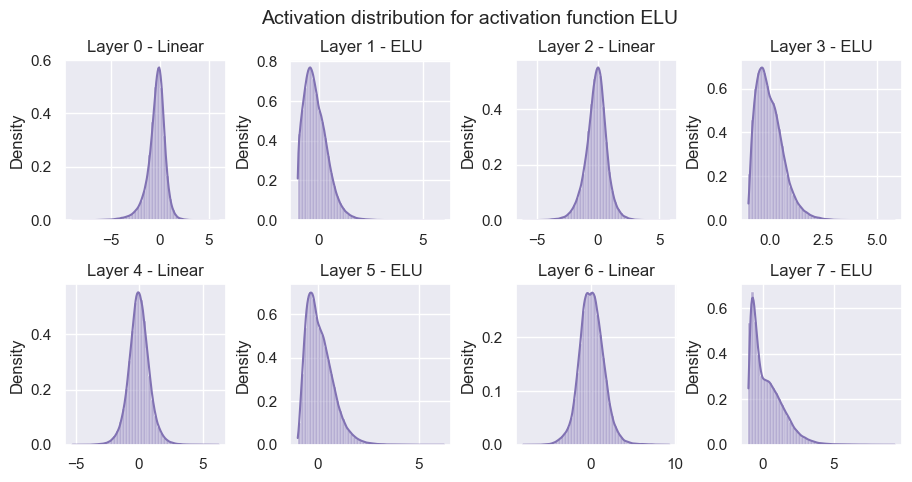

{0: tensor([ 0.1593, -0.1824,  0.2545,  ..., -0.3643, -0.9254,  0.4461]), 1: tensor([ 0.0860, -0.0829,  0.1433,  ..., -0.1493, -0.2627,  0.2720]), 2: tensor([ 0.0079, -0.3895, -0.2928,  ..., -0.1149, -0.1628, -0.0137]), 3: tensor([ 0.0039, -0.1573, -0.1251,  ..., -0.0542, -0.0748, -0.0068]), 4: tensor([-1.6067,  1.8273, -0.2946,  ...,  1.1467,  1.0864, -0.0222]), 5: tensor([-0.2684,  1.5741, -0.1257,  ...,  0.8703,  0.8123, -0.0110]), 6: tensor([ 1.7661, -2.4153,  0.9695,  ..., -0.6264, -0.7968, -1.0061]), 7: tensor([ 1.5082, -0.1981,  0.7029,  ..., -0.2182, -0.2476, -0.2694])}


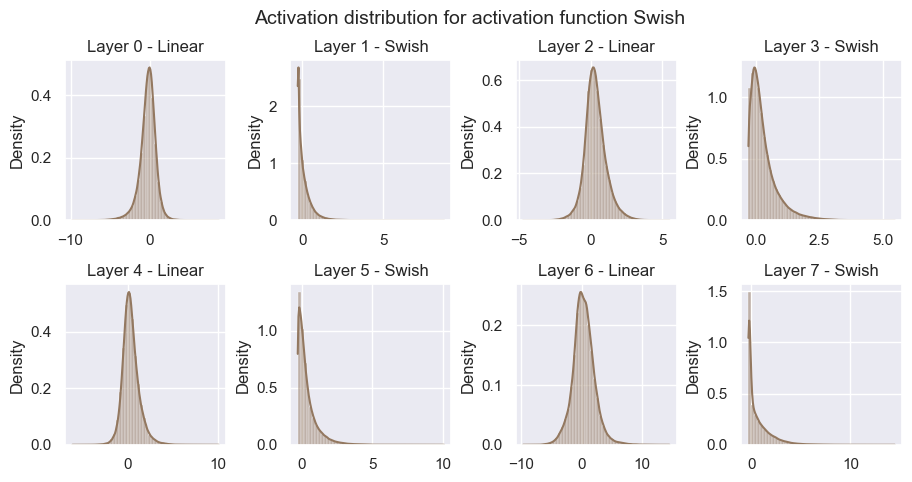

In [28]:
for i, act_fn_name in enumerate(act_fn_by_name):
    net_actfn = load_model(model_path=CHECKPOINT_PATH, model_name=f"FashionMNIST_{act_fn_name}").to(device)
    #print(net_actfn.eval())
    visualize_activations(net_actfn, color=f"C{i}")

As the model with sigmoid activation was not able to train properly, the activations are also less informative and all gathered around 0.5 (the activation at input 0).

The tanh shows a more diverse behavior. While for the input layer we experience a larger amount of neurons to be close to -1 and 1, where the gradients are close to zero, the activations in the two consecutive layers are closer to zero. This is probably because the input layers look for specific features in the input image, and the consecutive layers combine those together. The activations for the last layer are again more biased to the extreme points because the classification layer can be seen as a weighted average of those values (the gradients push the activations to those extremes).

The ReLU has a strong peak at 0, as we initially expected. The effect of having no gradients for negative values is that the network does not have a Gaussian-like distribution after the linear layers, but a longer tail towards the positive values. 
The LeakyReLU shows a very similar behavior while ELU follows again a more Gaussian-like distribution. 
The Swish activation seems to lie in between, although it is worth noting that Swish uses significantly higher values than other activation functions (up to 20).

As all activation functions show slightly different behavior although obtaining similar performance for our simple network, it becomes apparent that the selection of the "optimal" activation function really depends on many factors, and is not the same for all possible networks.

### Finding dead neurons in ReLU networks

One known drawback of the ReLU activation is the occurrence of "dead neurons", i.e. neurons with no gradient for any training input.

Given our training model is based on finding the gradient of the loss function with respect to each layer's parameters. The dead neurons therefore mean we cannot train the parameters of this neuron in the previous layer to obtain output values besides zero.
For dead neurons to happen, the output value of a specific neuron of the linear layer before the ReLU has to be negative for all input images.
Considering the large number of neurons we have in a neural network, it is not unlikely for this to happen. 

To get a better understanding of how much of a problem this is, and when we need to be careful, we will measure how many dead neurons different networks have. For this, you need to implement a function which runs the network on the whole training set and records whether a neuron is exactly 0 for all data points or not:

In [32]:
def measure_number_dead_neurons(net):

    # For each neuron, we create a boolean variable initially set to 1. If it has an activation unequals 0 at any time,
    # we set this variable to 0. After running through the whole training set, only dead neurons will have a 1.
    neurons_dead = [
        torch.ones(layer.weight.shape[0], device=device, dtype=torch.bool) for layer in net.layers[:-1] if isinstance(layer, nn.Linear)
    ] # Same shapes as hidden size in BaseNetwork

    net.eval()
    with torch.no_grad():
        for imgs, labels in tqdm(train_loader, leave=False): # Run through whole training set
            layer_index = 0
            imgs = imgs.to(device)
            imgs = imgs.view(imgs.size(0),-1)
            for layer in net.layers[:-1]:
                imgs = layer(imgs)
                if isinstance(layer, ActivationFunction):
                    neurons_dead[layer_index] = torch.logical_and(neurons_dead[layer_index], (imgs == 0).all(dim = 0))
                    layer_index += 1
    number_neurons_dead = [t.sum().item() for t in neurons_dead]
    print("Number of dead neurons:", number_neurons_dead)
    print("In percentage:", ", ".join([f"{(100.0 * num_dead / tens.shape[0]):4.2f}%" for tens, num_dead in zip(neurons_dead, number_neurons_dead)]))

Now use your function to measure the number of dead neurons in an untrained ReLU activation function network:

In [33]:
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU()).to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 3, 10]
In percentage: 0.00%, 0.00%, 1.17%, 7.81%


We see that only a minor amount of neurons are dead, but that they increase with the depth of the layer.
However, this is not a problem for the small number of dead neurons we have as the input to later layers is changed due to updates to the weights of previous layers. Therefore, dead neurons in later layers can potentially become "alive"/active again. 

Try for a different activation function, what are you expecting?

In [34]:
set_seed(42)
net_elu = BaseNetwork(act_fn=ELU()).to(device)
measure_number_dead_neurons(net_elu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 0, 0]
In percentage: 0.00%, 0.00%, 0.00%, 0.00%


Now let us look at this for a trained ReLU network (with the same initialization):

In [35]:
net_relu = load_model(model_path=CHECKPOINT_PATH, model_name="FashionMNIST_relu").to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 2, 3]
In percentage: 0.00%, 0.00%, 0.78%, 2.34%


The number of dead neurons indeed decreased in the later layers. However, it should be noted that dead neurons are especially problematic in the input layer. As the input does not change over epochs (the training set is kept as it is), training the network cannot turn those neurons back active. Still, the input data has usually a sufficiently high standard deviation to reduce the risk of dead neurons.

Finally, check how the number of dead neurons behaves with increasing layer depth. For instance, try a 10-layer neural network with 256 nodes in the first 5 layers and 128 in the last 5:

In [36]:
set_seed(42)
net_relu = BaseNetwork(act_fn = ReLU(), hidden_sizes = [256]*5+[128]*5)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 7, 27, 89, 60, 58, 61, 72, 56]
In percentage: 0.00%, 0.00%, 2.73%, 10.55%, 34.77%, 46.88%, 45.31%, 47.66%, 56.25%, 43.75%


The number of dead neurons is significantly higher than before which harms the gradient flow especially in the first iterations. For instance, more than 56% of the neurons in the pre-last layer are dead which creates a considerable bottleneck.
Hence, it is advisible to use other nonlinearities like Swish for very deep networks.

## Conclusion

In this notebook, we have reviewed a set of six activation functions (sigmoid, tanh, ReLU, LeakyReLU, ELU, and Swish) in neural networks, and discussed how they influence the gradient distribution across layers. Sigmoid tends to fail deep neural networks as the highest gradient it provides is 0.25 leading to vanishing gradients in early layers. All ReLU-based activation functions have shown to perform well, and besides the original ReLU, do not have the issue of dead neurons. When implementing your own neural network, it is recommended to start with a ReLU-based network and select the specific activation function based on the properties of the network.

## References

[1] Ramachandran, Prajit, Barret Zoph, and Quoc V. Le. "Searching for activation functions." arXiv preprint arXiv:1710.05941 (2017). [Paper link](https://arxiv.org/abs/1710.05941) 